# Deep learning:

**DL** is a subset of machine learning that's based on artificial neural networks. The learning process is deep because the structure of artificial neural networks consists of multiple input, output, and hidden layers. Each layer contains units that transform the input data into information that the next layer can use for a certain predictive task. Thanks to this structure, a machine can learn through its own data processing

# -Step Model Life-Cycle
A model has a life-cycle,modeling a dataset and understanding the tf.keras API.
The five steps in the life-cycle are as follows:
   - Define the model.
   - Compile the model.
   - Fit the model.
   - Evaluate the model.
   - Make predictions.


In [1]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark.context import SparkContext 
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()#create spark session 
sc = spark.sparkContext#create sparkContext
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                                DecimalType,
                                LongType,
                                ArrayType,
                                TimestampType)
sample_schema = StructType([StructField("id",  IntegerType(), True),
                            StructField("timeAtServer", DoubleType(), True),
                            StructField("aircraft",  IntegerType(), True ),
                            StructField("latitude", DoubleType(), True),
                            StructField("longitude", DoubleType(), True  ),
                            StructField("baroAltitude", DoubleType(), True ),
                            StructField("geoAltitude", DoubleType(), True ),
                            StructField("numM",IntegerType(), True),
                            StructField("measurements", StringType(), True)           
                            ])
sample_aircarft = spark.read.csv("C:/PFE/TEST/training_1_category_1.csv",
                       header = True, 
                        schema = sample_schema)
#filter only right data :
sample_aircarft_filtred=sample_aircarft.filter((sample_aircarft.latitude !=0)
                                               |(sample_aircarft.longitude != 0)
                                               | (sample_aircarft.baroAltitude != 0)
                                               | (sample_aircarft.geoAltitude!= 0)
                                               | (sample_aircarft.geoAltitude!= 'null')
                                               | (sample_aircarft.measurements != 'NA'))
sample_aircarft =sample_aircarft.orderBy('aircraft','timeAtServer')
sensors_schema = StructType([StructField("serial", LongType(), True),
                            StructField("latitudes", DoubleType(), True ),
                            StructField("longitudes",DoubleType(), True),
                            StructField("height",DoubleType(), True),
                            StructField("type", StringType(), True)
                            ])
sensors = spark.read.csv("C:/PFE/TEST/sensors.csv",
                       header = True, 
                        schema = sensors_schema)
sample_aircarft.na.drop(how = 'all')
sample_aircarft.dropDuplicates()
sensors.na.drop(how = 'all')
sensors.dropDuplicates()
sensors_filtred=sensors.filter((sensors.latitudes !=0) & (sensors.longitudes != 0))
#let's check our work !
sample_aircarft_filtred.filter((sample_aircarft_filtred["latitude"] == "") | sample_aircarft_filtred["latitude"].isNull() | isnan(sample_aircarft_filtred["latitude"])).count()
#Amazing  we have 0 null , nan  values !!!! #eleminating null data 
sample_aircarft.na.drop(how = 'all')
sample_aircarft.dropDuplicates()
from pyspark.sql.functions import *
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("ArrayOfString",
                                                             split(col("measurements"), "\],\s*\[")
                                                             .cast(ArrayType(StringType()))
                                                             .alias("ArrayOfString"))                                           
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("sensors_informations",
                                                             explode_outer('ArrayOfString'))
sample_aircarft_filtred=sample_aircarft_filtred.withColumn("sensors_informations", 
                                                           regexp_replace(col("sensors_informations"), "[\\[\\]]", ""))
sample_aircarft_filtred=sample_aircarft_filtred.withColumn("sensors_informations",
                                                           split(col("sensors_informations"), ",\s*")
                                                           .cast(ArrayType(IntegerType())).alias("sensors informations"))
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("serial_F",
                                                             sample_aircarft_filtred["sensors_informations"]
                                                             .getItem(0).cast(DoubleType()))
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("timestamp",
                                                             sample_aircarft_filtred["sensors_informations"]
                                                             .getItem(1).cast(LongType()))
sample_aircarft_filtred= sample_aircarft_filtred.withColumn("signalstrength",
                                                            sample_aircarft_filtred["sensors_informations"]
                                                            .getItem(2).cast(DoubleType()))
#==>Data integration: Using multiple databases
#spatial join sesnors data + aircrafts data , i used inner join 
joined_aircarft_sensors=sample_aircarft_filtred.join(sensors_filtred,
                                                     sample_aircarft_filtred.serial_F == sensors_filtred.serial,
                                                     'inner')
import pyspark.sql.functions as F
from pyspark.sql.window import Window
joined_aircarft_sensors =joined_aircarft_sensors.orderBy('aircraft','timeAtServer')
columns = [F.col("serial_F"),F.col("latitudes"),
           F.col("longitudes"),F.col("signalstrength"),
            F.col("height")] 
Grouped_aircarft_sensors = joined_aircarft_sensors.withColumn('sensor_infos',F.array(columns))
Grouped_aircarft_sensors=Grouped_aircarft_sensors.orderBy('aircraft','timeAtServer')
my_window = Window.partitionBy('aircraft','timeAtServer').orderBy("timeAtServer")
Grouped_aircarft_sensors=Grouped_aircarft_sensors.withColumn('All_sensor_infos', 
                                                            collect_list('sensor_infos'              
                                                            ).over(my_window))
Grouped_aircarft_sensors=Grouped_aircarft_sensors.dropDuplicates(['aircraft', 'timeAtServer'])
import numpy as np
import pandas as pd
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# Convert the Spark DataFrame back to a Pandas DataFrame using Arrow
Grouped_aircarft_sensors=Grouped_aircarft_sensors.withColumn('infos_Flatten',
                                                             flatten(Grouped_aircarft_sensors.All_sensor_infos).alias('infos_Flatten'))
# will pad our sequaences of data , max =13 * 5 =65 senors in our data 
#but i will chose only 4 sensors so we have 4*5=20;==> in deployment we must use max sensors or more data  
pad_fix_length = F.udf(
    lambda arr: arr[:20] + [0.00000000008] * (20- len(arr[:20])), 
    ArrayType(DoubleType())
)
Grouped_aircarft_sensors=Grouped_aircarft_sensors.withColumn('infos_Flatten_pad',
                                                             pad_fix_length(Grouped_aircarft_sensors.infos_Flatten).alias('infos_Flatten_pad'))


In [2]:
#filter only right data :
Grouped_aircarft_sensors=Grouped_aircarft_sensors.orderBy('aircraft','timeAtServer')
Grouped_aircarft_sensors=Grouped_aircarft_sensors.dropDuplicates(['aircraft', 'timeAtServer'])
Grouped_aircarft_sensors=Grouped_aircarft_sensors.select('baroAltitude','infos_Flatten_pad','latitude','longitude')
Grouped_aircarft_sensors=Grouped_aircarft_sensors.dropna()
Grouped_aircarft_sensors=Grouped_aircarft_sensors.na.drop()

In [3]:
Grouped_aircarft_sensors.count()

1905533

In [4]:
Grouped_aircarft_sensors=Grouped_aircarft_sensors.limit(1250000)

In [5]:
#Take a sample :
Grouped_aircarft_sensors.count()

1250000

In [6]:
Grouped_aircarft_sensors=Grouped_aircarft_sensors.select('baroAltitude','infos_Flatten_pad','latitude','longitude')
Grouped_aircarft_sensors.printSchema()

root
 |-- baroAltitude: double (nullable = true)
 |-- infos_Flatten_pad: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [7]:
Grouped_aircarft_sensors.show(3)

+------------+--------------------+----------------+----------------+
|baroAltitude|   infos_Flatten_pad|        latitude|       longitude|
+------------+--------------------+----------------+----------------+
|      2400.3|[440.0, 50.048573...|49.8963643736759|8.40246252111487|
|     2407.92|[101.0, 50.048584...|49.8959454035355|8.40149750580659|
|     2415.54|[101.0, 50.048584...|49.8956660901086|8.40075518633868|
+------------+--------------------+----------------+----------------+
only showing top 3 rows



In [8]:
#last thing convert our array to vectir 
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
list_to_vector_udf = F.udf(lambda l: Vectors.dense(l), VectorUDT())
Grouped_aircarft_sensors=Grouped_aircarft_sensors.withColumn('VectorUDT', list_to_vector_udf('infos_Flatten_pad').alias("VectorUDT"))
Grouped_aircarft_sensors=Grouped_aircarft_sensors.select('baroAltitude','VectorUDT','latitude','longitude')
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
# I provide two other ways to build the features and labels
# method 1 (good for small feature):
# Create features colmun
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["baroAltitude",'VectorUDT'],outputCol="features")

Grouped_aircarft_sensors=Grouped_aircarft_sensors.select("baroAltitude",'VectorUDT','latitude','longitude')
Grouped_aircarft_sensors=assembler.transform(Grouped_aircarft_sensors)
Grouped_aircarft_sensors.printSchema()

root
 |-- baroAltitude: double (nullable = true)
 |-- VectorUDT: vector (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- features: vector (nullable = true)



In [10]:
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[-1]),r[2],r[3]]).toDF(['featuresc','latitude','longitude'])
Grouped_aircarft_sensors= transData(Grouped_aircarft_sensors)

In [11]:
Grouped_aircarft_sensors.show(3)

+--------------------+----------------+----------------+
|           featuresc|        latitude|       longitude|
+--------------------+----------------+----------------+
|[2400.3,440.0,50....|49.8963643736759|8.40246252111487|
|[2407.92,101.0,50...|49.8959454035355|8.40149750580659|
|[2415.54,101.0,50...|49.8956660901086|8.40075518633868|
+--------------------+----------------+----------------+
only showing top 3 rows



In [12]:
def get_dummy(df,categoricalCols,continuousCols,labelCol1,labelCol2):
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder,VectorAssembler
    from pyspark.sql.functions import col
    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categoricalCols ]
     # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers ]
    
    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]+ continuousCols, outputCol="features")
    
    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    model=pipeline.fit(df)
    data = model.transform(df)
    data = data.withColumn('latitude',col(labelCol1))
    data = data.withColumn('longitude',col(labelCol2))
    return data.select('features','latitude','longitude')

catcols = []
num_cols = ['featuresc']
labelCol1='latitude'
labelCol2='longitude'
Grouped_aircarft_sensors= get_dummy(Grouped_aircarft_sensors,catcols,num_cols,labelCol1,labelCol2)
Grouped_aircarft_sensors.show(3)

+--------------------+----------------+----------------+
|            features|        latitude|       longitude|
+--------------------+----------------+----------------+
|[2400.3,440.0,50....|49.8963643736759|8.40246252111487|
|[2407.92,101.0,50...|49.8959454035355|8.40149750580659|
|[2415.54,101.0,50...|49.8956660901086|8.40075518633868|
+--------------------+----------------+----------------+
only showing top 3 rows



In [13]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler

# Let us create an object of MinMaxScaler class
MinMaxScaler1=MinMaxScaler().setInputCol("features").setOutputCol("Scaled_features")
# Make predictions.
Grouped_aircarft_sensors = MinMaxScaler1.fit(Grouped_aircarft_sensors).transform(Grouped_aircarft_sensors)
# Select example rows to display.
Grouped_aircarft_sensors.select("features",'Scaled_features','latitude',"longitude").show(3)

+--------------------+--------------------+----------------+----------------+
|            features|     Scaled_features|        latitude|       longitude|
+--------------------+--------------------+----------------+----------------+
|[2400.3,440.0,50....|[0.16713404374649...|49.8963643736759|8.40246252111487|
|[2407.92,101.0,50...|[0.16769489624228...|49.8959454035355|8.40149750580659|
|[2415.54,101.0,50...|[0.16825574873808...|49.8956660901086|8.40075518633868|
+--------------------+--------------------+----------------+----------------+
only showing top 3 rows



In [14]:
Grouped_aircarft_sensors=Grouped_aircarft_sensors.select('Scaled_features','latitude','longitude')
# Number of Inputs or Input Dimensions
input_dim = len(Grouped_aircarft_sensors.select("Scaled_features").first()[0])
input_dim

21

In [15]:
#Take a sample :
Grouped_aircarft_sensors=Grouped_aircarft_sensors.sample(False,0.8)
pandas = pd.DataFrame.from_records(Grouped_aircarft_sensors.collect(), columns=Grouped_aircarft_sensors.columns)
pandas.shape

(999824, 3)

In [46]:
pandas[0:2]

,Scaled_features,latitude,longitude
0,"[0.1671340437464947, 0.9207708779443254, 0.559...",49.896364,8.402463
1,"[0.1676948962422883, 0.1948608137044968, 0.559...",49.895945,8.401498


In [47]:
pandas.describe()
#https://towardsdatascience.com/distributed-deep-learning-pipelines-with-pyspark-and-keras-a3a1c22b9239

,latitude,longitude
count,999824.000000,999824.000000
mean,49.244284,7.477732
std,2.875549,4.478907
min,31.153656,-10.353679
25%,47.345261,5.642073
50%,49.344772,8.010109
75%,51.174782,10.082124
max,61.691631,25.098621


In [48]:
#https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# X = pandas.iloc[:,0].values
y = pandas.iloc[:,1:].values
y

array([[49.89636437,  8.40246252],
       [49.8959454 ,  8.40149751],
       [49.89566609,  8.40075519],
       ...,
       [47.6751709 , 11.3939209 ],
       [47.6778717 , 11.39378357],
       [47.68354797, 11.39344025]])

In [49]:
y.shape

(999824, 2)

### Convert Dense Vector to Matrix
we convert Dense vector to a python array by calling toArray method. Then we use numpy as_matrix method to convert to the two dimensional arrays.
If you observe the shape of series, it looks as below

In [50]:
series = pandas['Scaled_features'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)

C:\Users\rzouga\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [51]:
series[2000:2001]

array([[array([7.08356702e-01, 6.68094218e-01, 6.36965652e-01, 3.94807534e-01,
       1.45098039e-01, 0.00000000e+00, 3.87580300e-01, 6.78141919e-01,
       2.38395788e-01, 1.72549020e-01, 2.62061589e-02, 0.00000000e+00,
       0.00000000e+00, 3.39539970e-01, 3.13725490e-13, 1.07007564e-03,
       0.00000000e+00, 0.00000000e+00, 2.73630086e-01, 3.13725490e-13,
       1.07007564e-03])]], dtype=object)

From the result, it can be seen that there three dimensional array , where as we only need two-dimensional. This is happening because when we call apply and if it returns a sequence, python treat it as single value.

###  Flatten using apply_along_axis
we are flattening the innermost array

In [52]:
features = np.apply_along_axis(lambda x : x[0], 1, series)
features[2000:2001] 

array([[7.08356702e-01, 6.68094218e-01, 6.36965652e-01, 3.94807534e-01,
        1.45098039e-01, 0.00000000e+00, 3.87580300e-01, 6.78141919e-01,
        2.38395788e-01, 1.72549020e-01, 2.62061589e-02, 0.00000000e+00,
        0.00000000e+00, 3.39539970e-01, 3.13725490e-13, 1.07007564e-03,
        0.00000000e+00, 0.00000000e+00, 2.73630086e-01, 3.13725490e-13,
        1.07007564e-03]])

In [53]:
X=features 
X.shape 

(999824, 21)

In [54]:
from sklearn.preprocessing import  MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaling laltitude , longitude 
sc2= MinMaxScaler()
y=sc2.fit_transform(y)
y[2000:2003]

array([[0.73166968, 0.37048636],
       [0.73313768, 0.36712086],
       [0.73693497, 0.35837329]])

# Multilayer Perceptron:

In [55]:
def build_model():
    model1 = tf.keras.Sequential()
    model1.add( layers.Dense(528, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01),
                             input_shape=[X.shape[1]]))
    model1.add(layers.Dropout(0.4))
    model1.add(layers.Dense(264, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model1.add(layers.Dropout(0.2))
    model1.add(layers.Dense(132, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model1.add(layers.Dropout(0.1))
    model1.add(layers.Dense(2))  
    #optimizer='adam'
    optimizer =tf.keras.optimizers.Adam()
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
     ## Compile model
    #epochs = 50
    #learning_rate = 0.1
    #decay_rate = learning_rate / epochs
    #momentum = 0.8
    #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    #https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/
    #optimizer=sgd
    model1.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model1

model1 = build_model()
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 528)               11616     
_________________________________________________________________
dropout_3 (Dropout)          (None, 528)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 264)               139656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 132)               34980     
_________________________________________________________________
dropout_5 (Dropout)          (None, 132)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

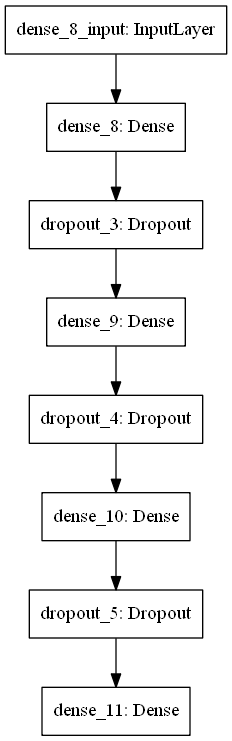

In [56]:
# plot graph
import graphviz
import pydot
import os     
os.environ["PATH"] += os.pathsep + 'C:/Users/rzouga/Anaconda3/Library/bin/graphviz'
tf.keras.utils.plot_model(model1, to_file='multilayer_perceptron_graph.png')

**min_delta** : minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

**patience** : number of epochs with no improvement after which training will be stopped.


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
EPOCHS =1000
# configure early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0.0000000000001, patience=5)
#batch_size=1000
history = model1.fit(
 X_train, y_train,batch_size=64,
  epochs=EPOCHS, validation_split = 0.2, verbose=0 ,callbacks=[es])

In [58]:
model1.save('my_model1MLP.h5') 

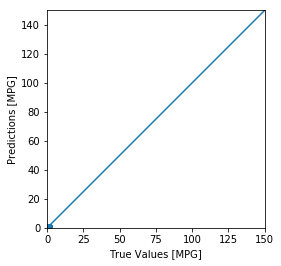

In [59]:
y_predictions = model1.predict(X_test)
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 150]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

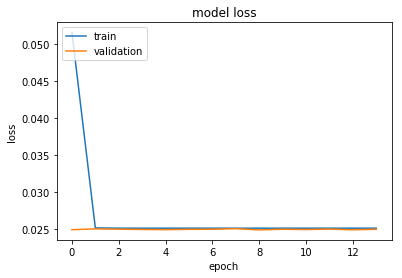

In [60]:
#Let’s see what this looks like when we plot our respective losses:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [61]:
# evaluate the keras model
loss1, mae1, mse1 = model1.evaluate( X_test, y_test, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae1))

199965/1 - 36s - loss: 0.0243 - mae: 0.0839 - mse: 0.0124
Testing set Mean Abs Error:  0.08 MPG


In [62]:
predictions1 = model1.predict(X_test)
predictions1[0:3]

array([[0.5922497, 0.5001321],
       [0.5922497, 0.5001321],
       [0.5922497, 0.5001321]], dtype=float32)

In [109]:
predictions1 = model1.predict(X_test)
yp=sc2.inverse_transform(predictions1[50].reshape(1,-1))
yp

array([[49.239765,  7.377154]], dtype=float32)

In [108]:
yt=sc2.inverse_transform(y_test[50].reshape(1,-1))
yt

array([[47.85057973, 12.08355243]])

In [69]:
# summarize the first 3cases
#for i in range(3):
 #   print('%s => %d (expected %d)' % (X_test[i].tolist(),
 #                                     sc2.inverse_transform(predictions1[i].reshape(1, -1)), 
  #                                    sc2.inverse_transform(y_test[i].reshape(1, -1))))

# Time Series
Time Series is a collection of data points indexed based on the time they were collected. Most often, the data is recorded at regular time intervals.
Forecasting future Time Series values is a quite common problem in practice. 
Our set  is a time series geospatial data 
# Recurrent Neural Networks
Recurrent neural networks (RNNs) can predict the next value(s) in a sequence or classify it. A sequence is stored as a matrix, where each row is a feature vector that describes it. Naturally, the order of the rows in the matrix is important.
As you might’ve already guessed, Time Series is just one type of a sequence. We’ll have to cut the Time Series into smaller sequences, so our RNN models can use them for training.
# Data Preprocessing

We need to “chop the data” into smaller sequences for our model.
Preparing the data for Time Series forecasting (LSTMs in particular) can be tricky. Intuitively, we need to predict the value at the current time step by using the history (n time steps from it). Here’s a generic function that does the job:
We need to reshape our data into three dimensions so that it can be used by LSTM.
The input to LSTM layer should be in 3D shape i.e. (samples, time-steps, features). The samples are the number of samples in the input data.We have 990965 rows'samples' in total and 21 columns in our dataset. We will reshape our dataset into 990965 samples, 3 time-steps, and 21 features.

In [71]:
def create_dataset1(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
# For timesteps != 1, you can use the below function (adapted from here)

import numpy as np
def create_dataset2(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back+1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back - 1, :])
    return np.array(dataX), np.array(dataY)
# or we can use reshape of numpy :
#X_data = X_data.reshape((10000,5,30))
#X = np.reshape(X, (len(X), 5, X.shape[1]))
#https://www.curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/#recurrent-neural-networks
#https://stackoverflow.com/questions/44704435/error-when-checking-model-input-expected-lstm-1-input-to-have-3-dimensions-but
X1, y1=create_dataset1(X, y,3)
print(X1.shape, y1.shape)

(999821, 3, 21) (999821, 2)


In [72]:
X_train1=X1[0:900000]
X_test1=X1[900000:]
y_train1=y1[0:900000]
y_test1=y1[900000:]
print(X_train1.shape,X_test1.shape,y_train1.shape, y_test1.shape)

(900000, 3, 21) (99821, 3, 21) (900000, 2) (99821, 2)


# Solution via Simple LSTM

Let's now create our model with one LSTM layer:

In [73]:
#https://morioh.com/p/9f28ce66f1a7
#https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/, evaluation grid search
#Solution via Simple LSTM
def build_model():
    model2 = tf.keras.Sequential()
    model2.add(layers.LSTM(50, activation='relu', input_shape=(3, 21)))
    model2.add(layers.Dense(2))  
    #optimizer='adam'
    optimizer =tf.keras.optimizers.Adam()
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
     ## Compile model
    #epochs = 50
    #learning_rate = 0.1
    #decay_rate = learning_rate / epochs
    #momentum = 0.8
    #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    #optimizer=sgd
    model2.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model2
model2 = build_model()
history = model2.fit(X_train1, y_train1,batch_size=64, epochs=1000, validation_split=0.1, verbose=0,callbacks=[es])

In [74]:
model2.save('my_model2LSTM.h5') 

In [75]:
# evaluate the keras model
loss2, mae2, mse2 = model2.evaluate( X_test1, y_test1, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae2))

99821/1 - 15s - loss: 1.8407e-04 - mae: 0.0124 - mse: 3.3809e-04
Testing set Mean Abs Error:  0.01 MPG


In [97]:
test_output = model2.predict(X_test1, verbose=0)
yp=sc2.inverse_transform(test_output[1].reshape(1,-1))
yp

array([[52.58566  ,  6.7899394]], dtype=float32)

In [98]:
yt=sc2.inverse_transform(y_test1[1].reshape(1,-1))
yt

array([[52.37638829,  6.94445801]])

# Solution via Stacked LSTM
Let's now create a more complex LSTM with multiple LSTM and dense layers and see if we can improve our answer:

In [78]:
#Solution via Stacked LSTM
#The following script trains a stacked LSTM and makes predictions on test point:
def build_model():
    model3 = tf.keras.Sequential()
    model3.add(layers.LSTM(200, activation='relu',return_sequences=True, input_shape=(3, 21)))
    model3.add(layers.LSTM(100, activation='relu',return_sequences=True))
    model3.add(layers.LSTM(50, activation='relu',return_sequences=True))
    model3.add(layers.LSTM(25, activation='relu'))
    model3.add(layers.Dense(20, activation='relu'))
    model3.add(layers.Dense(10, activation='relu'))
    model3.add(layers.Dense(2))  
    #optimizer='adam'
    optimizer =tf.keras.optimizers.Adam()
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
     ## Compile model
    #epochs = 50
    #learning_rate = 0.1
    #decay_rate = learning_rate / epochs
    #momentum = 0.8
    #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    #optimizer=sgd
    model3.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model3
model3 = build_model()
history = model3.fit(X_train1, y_train1,batch_size=64, epochs=1000, validation_split=0.1,verbose=0,callbacks=[es])

In [79]:
model3.save('my_model3StackLSTM.h5') 

In [80]:
# evaluate the keras model
loss3, mae3, mse3 = model3.evaluate( X_test1, y_test1, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae3))

99821/1 - 55s - loss: 4.8476e-04 - mae: 0.0134 - mse: 3.8006e-04
Testing set Mean Abs Error:  0.01 MPG


In [94]:
test_output1 = model3.predict(X_test1, verbose=0)
yp=sc2.inverse_transform(test_output1[1].reshape(1,-1))
yp

array([[52.854713 ,  7.6524935]], dtype=float32)

In [96]:
yt=sc2.inverse_transform(y_test1[1].reshape(1,-1))
yt

array([[52.37638829,  6.94445801]])

# Solution via Bidirectional LSTM
Bidirectional LSTM is a type of LSTM which learns from the input sequence from both forward and backward directions. The final sequence interpretation is the concatenation of both forward and backward learning passes. Let's see if we can get better results with bidirectional LSTMs.
The following script creates a bidirectional LSTM model with one bidirectional layer and one dense layer which acts as the output of the model.

In [83]:
def build_model():
    model4 = tf.keras.Sequential()
    model4.add(layers.Bidirectional(layers.LSTM(200, activation='relu'), input_shape=(3, 21)))
    model4.add(layers.Dense(2))  
    #optimizer='adam'
    optimizer =tf.keras.optimizers.Adam()
    #https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
     ## Compile model
    #epochs = 50
    #learning_rate = 0.1
    #decay_rate = learning_rate / epochs
    #momentum = 0.8
    #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    #optimizer=sgd
    model4.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model4
model4 = build_model()
history = model4.fit(X_train1, y_train1, batch_size=64,epochs=1000, validation_split=0.1, verbose=0,callbacks=[es])

In [84]:
model4.save('my_model4BIDIRECTIONALLSTM.h5') 

In [85]:
# evaluate the keras model
loss4, mae4, mse4 = model4.evaluate( X_test1, y_test1, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae4))

99821/1 - 36s - loss: 1.5494e-04 - mae: 0.0103 - mse: 2.6670e-04
Testing set Mean Abs Error:  0.01 MPG


In [100]:
test_output2 = model4.predict(X_test1, verbose=0)
yp=sc2.inverse_transform(test_output2[1].reshape(1,-1))
yp

array([[52.711163 ,  7.1750293]], dtype=float32)

In [99]:
yt=sc2.inverse_transform(y_test1[1].reshape(1,-1))
yt

array([[52.37638829,  6.94445801]])

# Conclusion

Simple neural networks are not suitable for solving sequence problems since in sequence problems, in addition to current input, we need to keep track of the previous inputs as well. Neural Networks with some sort of memory are more suited to solving sequence problems. LSTM is one such network.